# World Bank Educational Data Analysis for academy EdTech Platform

This notebook analyzes World Bank EdStats data to identify international expansion opportunities for academy's EdTech platform. We'll explore educational indicators across countries to determine the most promising markets for expansion.

## 1. Loading and Initial Exploration

In [1]:
import os
import pandas as pd
import glob


# Get the current working directory (notebook's directory)
notebook_directory = os.getcwd()

# Relative path to the dataset directory
dataset_directory = 'Dataset'

dfs = {}
csv_files = glob.glob(os.path.join(notebook_directory, dataset_directory, "*.csv"))

for file_path in csv_files:
    # Extract just the filename without extension
    file_name = os.path.splitext(os.path.basename(file_path))[0]

    df = pd.read_csv(file_path)

    # Drop columns that are entirely empty
    df = df.dropna(axis=1, how='all')

    dfs[file_name] = df

    print(f"Loaded: {file_name} ({df.shape[0]} rows, {df.shape[1]} columns)")


Loaded: EdStatsCountry-Series (613 rows, 3 columns)
Loaded: EdStatsCountry (241 rows, 31 columns)
Loaded: EdStatsData (886930 rows, 69 columns)
Loaded: EdStatsFootNote (643638 rows, 4 columns)
Loaded: EdStatsSeries (3665 rows, 15 columns)


## 2. Data Validation and Quality Assessment

Let's examine the data for quality issues, including missing values, duplicates, and other anomalies that might affect our analysis.


===== Missing Values in EdStatsCountry-Series =====
No missing values found.


<Figure size 1200x800 with 0 Axes>

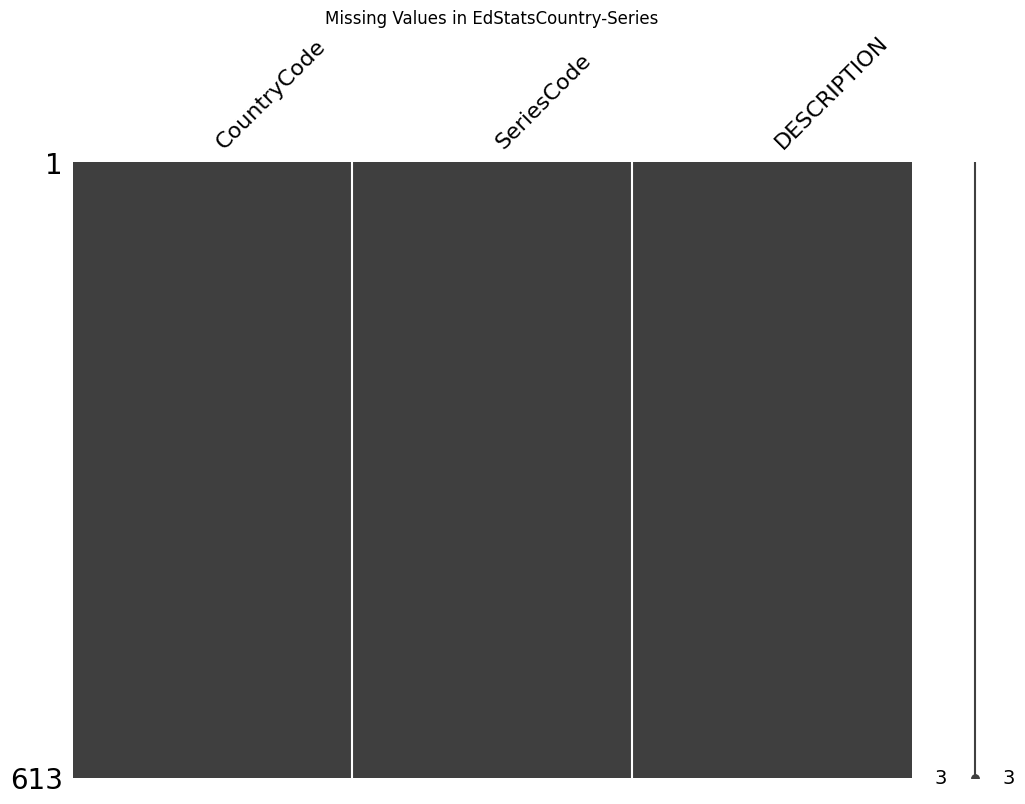


===== Missing Values in EdStatsCountry =====
                                                   Missing Values  Percentage
National accounts reference year                              209   86.721992
Alternative conversion factor                                 194   80.497925
Other groups                                                  183   75.933610
Latest industrial data                                        134   55.601660
Vital registration complete                                   130   53.941909
External debt Reporting status                                117   48.547718
Latest household survey                                       100   41.493776
Latest agricultural census                                     99   41.078838
Lending category                                               97   40.248963
Special Notes                                                  96   39.834025
PPP survey year                                                96   39.834025
Source of most rec

<Figure size 1200x800 with 0 Axes>

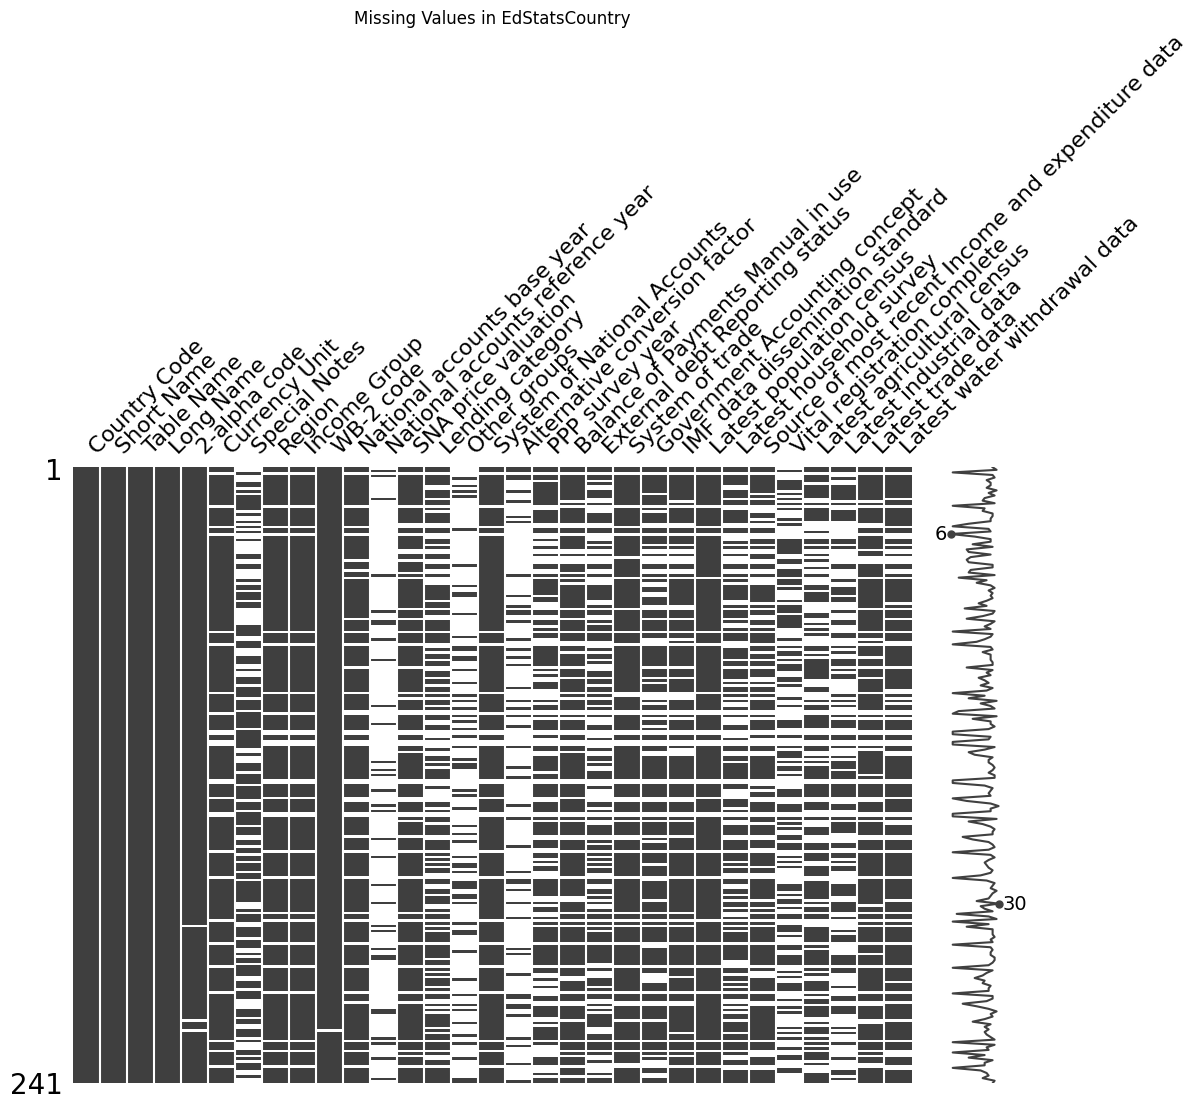


===== Missing Values in EdStatsData =====
      Missing Values  Percentage
2017          886787   99.983877
2016          870470   98.144160
1971          851393   95.993258
1973          851385   95.992356
1972          851311   95.984012
...              ...         ...
2011          740918   83.537370
2012          739666   83.396209
2000          710254   80.080051
2005          702822   79.242105
2010          644488   72.665036

[65 rows x 2 columns]


<Figure size 1200x800 with 0 Axes>

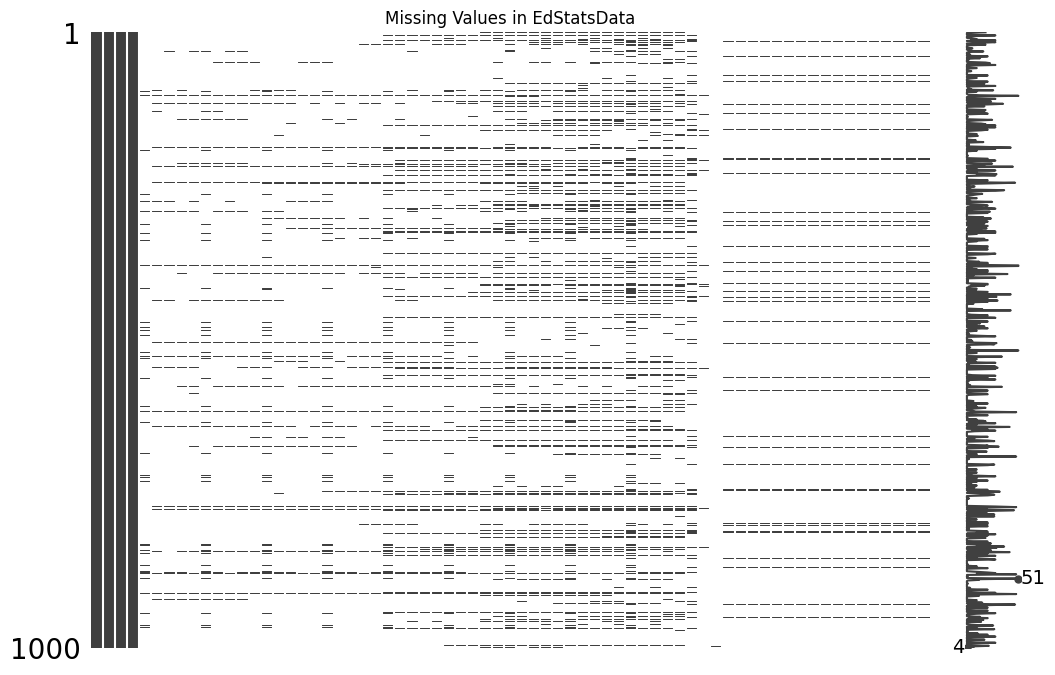


===== Missing Values in EdStatsFootNote =====
No missing values found.


<Figure size 1200x800 with 0 Axes>

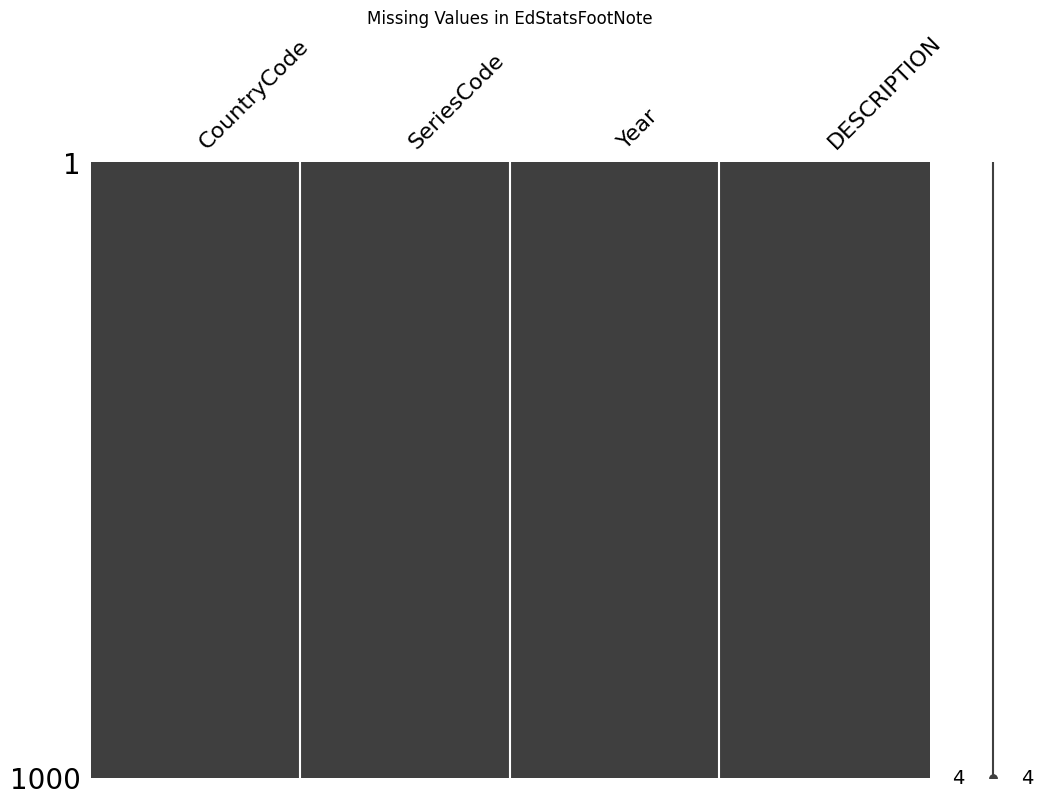


===== Missing Values in EdStatsSeries =====
                                     Missing Values  Percentage
Development relevance                          3662   99.918145
General comments                               3651   99.618008
Limitations and exceptions                     3651   99.618008
Statistical concept and methodology            3642   99.372442
Aggregation method                             3618   98.717599
Periodicity                                    3566   97.298772
Related source links                           3450   94.133697
Base Period                                    3351   91.432469
Other notes                                    3113   84.938608
Short definition                               1509   41.173261


<Figure size 1200x800 with 0 Axes>

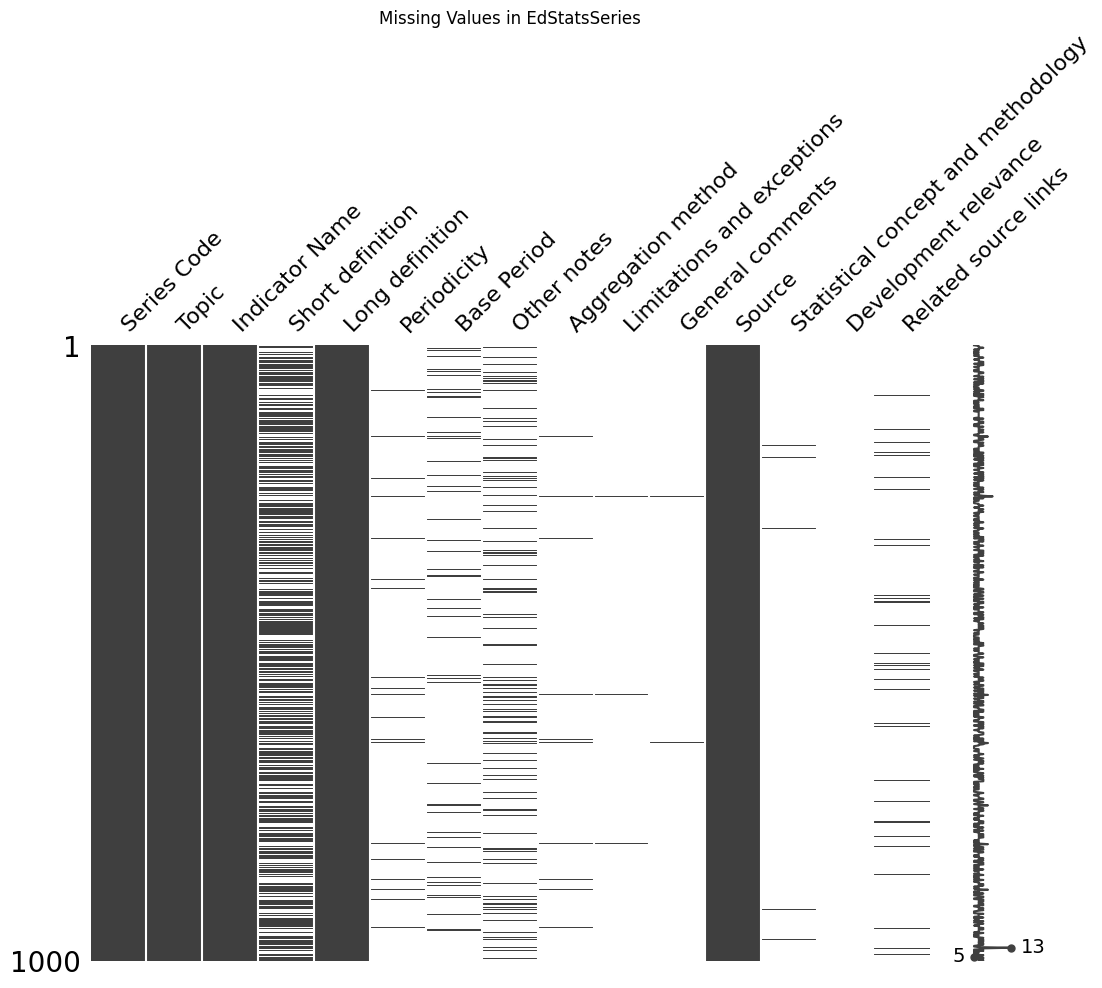

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno

def check_missing_values(dfs):
    """
    Analyzes and visualizes missing values in each DataFrame in the provided dictionary.
    
    Parameters:
    - dfs (dict): Dictionary of DataFrames where keys are DataFrame names
    """
    for df_name, df in dfs.items():
        # Calculate missing values and percentages
        missing = df.isnull().sum()
        missing_percent = (missing / len(df)) * 100
        missing_data = pd.DataFrame({
            'Missing Values': missing,
            'Percentage': missing_percent
        }).sort_values('Percentage', ascending=False)
        
        # Filter to only show columns with missing values
        missing_data = missing_data[missing_data['Missing Values'] > 0]
        
        # Print results
        print(f"\n===== Missing Values in {df_name} =====")
        if missing_data.empty:
            print("No missing values found.")
        else:
            print(missing_data)
        
        # Create visualization using missingno
        if len(df) > 0:  # Only create visualization if DataFrame is not empty
            plt.figure(figsize=(12, 8))
            msno.matrix(df.sample(min(1000, len(df))), figsize=(12, 8))
            plt.title(f'Missing Values in {df_name}')
            plt.show()

# Check for missing values
check_missing_values(dfs)

In [3]:
from src.scripts.data_validator import DataValidator

# Create an instance
validator = DataValidator()

# Generate metadata for all dataframes
metadata_dfs = validator.create_metadata_dfs(dfs)

# Display the metadata
validator.display_metadata_dfs(metadata_dfs) 

# Check for duplicates
ignore_fields = {
    'EdStatsCountry-Series': ['DESCRIPTION'],
    'EdStatsCountry': ['Special Notes'],
    'EdStatsFootNote': ['DESCRIPTION'],
    'EdStatsSeries': ['Short definition']
}

mandatory_fields = {
    'EdStatsCountry-Series': ['CountryCode','SeriesCode'],
    'EdStatsCountry': ['Country Code','Table Name'],
    'EdStatsData': ['Country Code','Indicator Code'],
    'EdStatsFootNote': ['CountryCode','SeriesCode','Year'],
    'EdStatsSeries': ['Series Code','Indicator Name']
}

duplicate_results = validator.check_duplicates(dfs, ignore_fields, mandatory_fields)

Metadata for metadata_EdStatsCountry-Series (613, 3):
   Column Name   Dtype      Type  Fill Percentage  NaN Percentage  \
0  CountryCode  object    str(3)            100.0             0.0   
1   SeriesCode  object   str(17)            100.0             0.0   
2  DESCRIPTION  object  str(278)            100.0             0.0   

   Bad Null Percentage  
0                  0.0  
1                  0.0  
2                  0.0  


Metadata for metadata_EdStatsCountry (241, 31):
                                          Column Name    Dtype       Type  \
0                                        Country Code   object     str(3)   
1                                          Short Name   object    str(46)   
2                                          Table Name   object    str(46)   
3                                           Long Name   object    str(73)   
4                                        2-alpha code   object     str(2)   
5                                       Currency Unit   o

## 3. Data Frame Simplification Based on Interesting KPIs

Now that we have a global overview of the structure and quality of the datasets, we will create a subset of data by focusing on the initial business need.

- **"We are an online education startup that wants to expand internationally, targeting French/English-speaking audiences aged 15 to 24 for high school to university level training."**

### 3.1 Filtering by Excluding Non-Relevant KPIs
We will code the filtering script to exclude non-relevant indicators based on our target audience and specific needs.

Below is a script that filters the educational data to focus only on the most relevant indicators for our target demographic (French/English-speaking audiences aged 15-24 in high school to university settings):

In [4]:
import re

def filter_kpis(EdStatsSeries):
    # List of terms to ignore in the 'Topic'
    ignore_list = ['Economic Policy', 'Education Equality', 'SABER', 'Early Childhood Education', 'Health', 'Social Protection', 'Population', 'Teachers', 'Pre-Primary', 'Primary', 'Learning Outcomes', 'Literacy']
    ignore_pattern = '|'.join(ignore_list).replace('%', '.*')

    # List of terms to ignore in the 'Indicator Name' for lower school levels
    school_level_ignore_list = ['1st', '2nd', '3rd', '4th', '5th', '6th', 'primary', 'No Education', 'Grade']
    school_level_ignore_pattern = '|'.join(school_level_ignore_list)

    # List of terms to ignore for gender-related entries
    gender_ignore_list = ['Female', 'Male', 'gender parity index', 'male (%)', 'toilets', 'male (number)', 'male (years)']
    gender_ignore_pattern = '|'.join(re.escape(term) for term in gender_ignore_list)

    # Define the pattern to exclude entries related to ages over 24 or under 15
    age_pattern = r'age\s*(?:[0-9]|1[0-4]|2[5-9]|[3-9]\d|\d{3,})|\bage\s*(?:[0-9]\+|1[0-4]\+|2[5-9]\+|[3-9]\d\+|\d{3,}\+)|\bage\s*(?:[0-9]-\d{2,}|1[0-4]-\d{2,}|2[5-9]-\d{2,}|[3-9]\d-\d{2,}|\d{3,}-\d{2,})'

    # Define the pattern to keep rows with 'Learning Outcomes' if 'Indicator Name' contains 'French' or 'English'
    language_pattern = r'French|English'

    # Filter rows based on 'Topic' and 'Indicator Name', while keeping 'Learning Outcomes' with 'French' or 'English'
    filtered_df = EdStatsSeries[
        (~EdStatsSeries['Topic'].str.contains(ignore_pattern, regex=True) |
         ((EdStatsSeries['Topic'] == 'Learning Outcomes') & EdStatsSeries['Indicator Name'].str.contains(language_pattern, regex=True, case=False))) &
        ~EdStatsSeries['Indicator Name'].str.contains(age_pattern, regex=True, case=False) &
        ~EdStatsSeries['Indicator Name'].str.contains(school_level_ignore_pattern, regex=True, case=False) &
        ~EdStatsSeries['Indicator Name'].str.contains(gender_ignore_pattern, regex=True, case=False)
    ][['Topic', 'Series Code', 'Indicator Name', 'Short definition']].drop_duplicates()
    
    return filtered_df

# call the function
df_filtered_kpis = filter_kpis(dfs["EdStatsSeries"])

# Display the shape of the filtered DataFrame
print(f"Shape of the filtered DataFrame: {df_filtered_kpis.shape}")


Shape of the filtered DataFrame: (190, 4)


Fantastic! We've gone from a list of 3665 indicators down to just 190. This will make it much easier to make a selection.

### 3.2 Manual Filtering Based on a Scenario

#### For online training, learners need:
- Good quality internet connection
- A device to access it (PC, smartphone, tablet, etc.)
  => Search for one or more indicators on these infrastructure subjects

#### For easy international expansion, a common language between learners and the training center is needed
  => Search for an indicator on language proficiency in French (or English)

#### We need a socio-economic context and the ability to project with:
- Information on demographics and their evolution over at least 5-10 years in the target population segment
- Information on the evolution of education continuation rates for high school/university levels
- Information on the evolution of the education budget in the targeted segment
- Information on the evolution of the country's GDP
  => Search for a set of indicators to have a socio-economic vision and understand market opportunities generically

#### And the cherry on top:
- Any indicator that helps better understand the needs and desires of the future generation to ensure that the company's values align with the future market
  => Maximum 2 indicators to tell a story

#### Categories and Top KPIs

| Category | Indicator | Code |
|----------|-----------|------|
| **1. Internet Connection & Device Access** | Internet users (per 100 people) | IT.NET.USER.P2 |
|  | Personal computers (per 100 people) | IT.CMP.PCMP.P2 |
| **2. Language Proficiency** | Total inbound internationally mobile students | UIS.MS.56.T |
|  | Net flow ratio of internationally mobile students (%) | UIS.MENFR.56 |
|  | Inbound mobility rate (%) | UIS.MSEP.56 |
| **3. Socio-economic Context** | | |
| 3.1 Demographics | Projection: Population with Lower Secondary education (thousands) | PRJ.POP.ALL.2.MF |
|  | Projection: Population with Upper Secondary education (thousands) | PRJ.POP.ALL.3.MF |
|  | Projection: Population with Post Secondary education (thousands) | PRJ.POP.ALL.4.MF |
| 3.2 Education Continuation | Gross enrollment ratio, secondary (%) | SE.SEC.ENRR |
|  | Gross enrollment ratio, tertiary (%) | SE.TER.ENRR |
|  | Graduates from tertiary education (number) | SE.TER.GRAD |
| 3.3 Education Budget | Expenditure on secondary as % of government education expenditure | SE.XPD.SECO.ZS |
|  | Expenditure on tertiary as % of government education expenditure | SE.XPD.TERT.ZS |
|  | Government expenditure on education as % of GDP | SE.XPD.TOTL.GD.ZS |
| 3.4 GDP | (To be sourced from external data) | - |
| **4. Future Generation Needs** | Share of youth not in education, employment or training (%) | SL.UEM.NEET.ZS |
|  | Percentage of students in secondary vocational programs (%) | SE.SEC.ENRL.VO.ZS |

In [5]:
# List of Series Codes based on selected indicators
codeserielist = [
    "IT.NET.USER.P2",  # Internet users (per 100 people)
    "IT.CMP.PCMP.P2",  # Personal computers (per 100 people)
    "UIS.MS.56.T",  # Total inbound internationally mobile students, both sexes
    "UIS.MENFR.56",  # Net flow ratio of internationally mobile students (inbound - outbound), both sexes (%)
    "UIS.MSEP.56",  # Inbound mobility rate, both sexes (%)
    "PRJ.POP.ALL.2.MF",  # Projection: Population in thousands by highest level of educational attainment. Lower Secondary. Total
    "PRJ.POP.ALL.3.MF",  # Projection: Population in thousands by highest level of educational attainment. Upper Secondary. Total
    "PRJ.POP.ALL.4.MF",  # Projection: Population in thousands by highest level of educational attainment. Post Secondary. Total
    "SE.SEC.ENRR",  # Gross enrolment ratio, secondary, both sexes (%)
    "SE.TER.ENRR",  # Gross enrolment ratio, tertiary, both sexes (%)
    "SE.TER.GRAD",  # Graduates from tertiary education, both sexes (number)
    "SE.XPD.SECO.ZS",  # Expenditure on secondary as % of government expenditure on education (%)
    "SE.XPD.TERT.ZS",  # Expenditure on tertiary as % of government expenditure on education (%)
    "SE.XPD.TOTL.GD.ZS",  # Government expenditure on education as % of GDP (%)
    "SL.UEM.NEET.ZS",  # Share of youth not in education, employment or training, total (% of youth population)
    "SE.SEC.ENRL.VO.ZS"  # Percentage of students in secondary education enrolled in vocational programmes, both sexes (%)
]


# Filter the data based on the provided list of Series Codes
df_kpis = df_filtered_kpis[df_filtered_kpis["Series Code"].isin(codeserielist)]

df_kpis

Topic        Series Code  \
610   Infrastructure: Communications     IT.CMP.PCMP.P2   
611   Infrastructure: Communications     IT.NET.USER.P2   
1981                      Attainment   PRJ.POP.ALL.2.MF   
1984                      Attainment   PRJ.POP.ALL.3.MF   
1987                      Attainment   PRJ.POP.ALL.4.MF   
2306                       Secondary  SE.SEC.ENRL.VO.ZS   
2307                       Secondary        SE.SEC.ENRR   
2335                        Tertiary        SE.TER.ENRR   
2338                        Tertiary        SE.TER.GRAD   
2377                    Expenditures     SE.XPD.SECO.ZS   
2379                    Expenditures     SE.XPD.TERT.ZS   
2381                    Expenditures  SE.XPD.TOTL.GD.ZS   
2397                           Laber     SL.UEM.NEET.ZS   
3074                        Tertiary       UIS.MENFR.56   
3076                        Tertiary        UIS.MS.56.T   
3077                        Tertiary        UIS.MSEP.56   

                                         Indicator Name  \
610                 Personal computers (per 100 people)   
611                     Internet users (per 100 people)   
1981  Projection: Population in thousands by highest...   
1984  Projection: Population in thousands by highest...   
1987  Projection: Population in thousands by highest...   
2306  Percentage of students in secondary education ...   
2307   Gross enrolment ratio, secondary, both sexes (%)   
2335    Gross enrolment ratio, tertiary, both sexes (%)   
2338  Graduates from tertiary education, both sexes ...   
2377  Expenditure on secondary as % of government ex...   
2379  Expenditure on tertiary as % of government exp...   
2381  Government expenditure on education as % of GD...   
2397  Share of youth not in education, employment or...   
3074  Net flow ratio of internationally mobile stude...   
3076  Total inbound internationally mobile students,...   
3077              Inbound mobility rate, both sexes (%)   

                                       Short definition  
610                                                 NaN  
611                                                 NaN  
1981                                                NaN  
1984                                                NaN  
1987                                                NaN  
2306                                                NaN  
2307                                                NaN  
2335                                                NaN  
2338                                                NaN  
2377  Expenditure on education by level of education...  
2379  Expenditure on education by level of education...  
2381  Total general (local, regional and central) go...  
2397  Share of youth not in education, employment or...  
3074                                                NaN  
3076                                                NaN  
3077                                                NaN

### 3.3 Applying Filtering to our DataFrames

Once the relevant KPIs are identified, we will filter our DataFrames to keep only the columns of interest.



#### Reduction of EdStatsSeries

In [6]:
reduced_datasets = {}

# 1. Reduce EdStatsSeries
if "EdStatsSeries" in dfs:
    reduced_datasets["EdStatsSeries_reduced"] = dfs["EdStatsSeries"][
        dfs["EdStatsSeries"]["Series Code"].isin(df_kpis["Series Code"])
    ]
    print(f"EdStatsSeries_reduced: {reduced_datasets['EdStatsSeries_reduced'].shape}")

EdStatsSeries_reduced: (16, 15)


#### Reduction of EdStatsCountry

EdStatsCountry_reduced improves visibility by focusing on the necessary and sufficient columns for our study.
Additionally, we need to add a tag to distinguish between groups and countries.

In [7]:
# 2. Reduce EdStatsCountry
if "EdStatsCountry" in dfs:
    important_columns = [
        'Country Code', 'Short Name', 'Table Name', 'Long Name',
        'Region', 'Income Group'
    ]
    available_columns = [col for col in important_columns if col in dfs["EdStatsCountry"].columns]
    
    reduced_datasets["EdStatsCountry_reduced"] = dfs["EdStatsCountry"][available_columns].copy()
    
    # Add a 'Category' column
    if 'Income Group' in reduced_datasets["EdStatsCountry_reduced"].columns:
        reduced_datasets["EdStatsCountry_reduced"]['Category'] = reduced_datasets["EdStatsCountry_reduced"]['Income Group'].apply(
            lambda x: 'Country' if pd.notna(x) and 'income' in str(x).lower() else 'Unknown'
        )
    
    print(f"EdStatsCountry_reduced: {reduced_datasets['EdStatsCountry_reduced'].shape}")

EdStatsCountry_reduced: (241, 7)


#### Reduction of EdStatsData and EdStatsFootNote

- `EdStatsData_reduced`: Contains only the `Indicator Name` present in `EdStatsSeries_reduced`.
- `EdStatsFootNote_reduced`: Contains only the `Series Code` present in `EdStatsSeries_reduced`.

In [8]:
# 3. Reduce EdStatsData
if "EdStatsData" in dfs:
    # First filter by indicator codes
    data_reduced = dfs["EdStatsData"][dfs["EdStatsData"]["Indicator Code"].isin(df_kpis["Series Code"])]
    
    # Then filter by countries if available
    if "EdStatsCountry_reduced" in reduced_datasets and "Country Code" in data_reduced.columns:
        country_codes = reduced_datasets["EdStatsCountry_reduced"][
            reduced_datasets["EdStatsCountry_reduced"]['Category'] == 'Country'
        ]['Country Code'] if 'Category' in reduced_datasets["EdStatsCountry_reduced"].columns else None
        
        if country_codes is not None:
            data_reduced = data_reduced[data_reduced['Country Code'].isin(country_codes)]
    
    # Keep only necessary columns
    necessary_columns = ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code']
    year_columns = [str(year) for year in range(2000, 2036) if str(year) in data_reduced.columns]
    
    available_columns = [col for col in necessary_columns + year_columns if col in data_reduced.columns]
    reduced_datasets["EdStatsData_reduced"] = data_reduced[available_columns]
    
    print(f"EdStatsData_reduced: {reduced_datasets['EdStatsData_reduced'].shape}")

# 4. Reduce EdStatsFootNote if available
if "EdStatsFootNote" in dfs:
    if "SeriesCode" in dfs["EdStatsFootNote"].columns:
        reduced_datasets["EdStatsFootNote_reduced"] = dfs["EdStatsFootNote"][
            dfs["EdStatsFootNote"]["SeriesCode"].isin(df_kpis["Series Code"])
        ]
        print(f"EdStatsFootNote_reduced: {reduced_datasets['EdStatsFootNote_reduced'].shape}")


EdStatsData_reduced: (3424, 26)
EdStatsFootNote_reduced: (21323, 4)


### 5. Graphical Analysis

#### 5.1 Analysis Objective
The objective of this graphical analysis is to provide a visual overview of key performance indicators (KPIs) by country. This approach allows for quickly identifying trends and anomalies across different countries and indicators.

#### 5.2 Methodology
1. Data Aggregation: For each country and each KPI, we use the latest available value to ensure relevant and up-to-date analysis.
2. Heatmaps: Heatmaps are used to visualize data intuitively and identify strengths and weaknesses by country and indicator.


In [9]:
# Import necessary modules
from src.classes.analyze_edstats import EdStatsVisualizer


# Initialize the visualizer with your reduced datasets
visualizer = EdStatsVisualizer(
    data_reduced=reduced_datasets["EdStatsData_reduced"],
    series_reduced=reduced_datasets["EdStatsSeries_reduced"],
    country_reduced=reduced_datasets["EdStatsCountry_reduced"]
)

# Extract latest values
year_columns = [str(year) for year in range(2000, 2036) if str(year) in reduced_datasets["EdStatsData_reduced"].columns]
latest_values = visualizer.extract_latest_values(year_columns)

# Calculate statistics
stats = visualizer.calculate_statistics()
print("Statistics summary:")

stats

Statistics summary:


Indicator Name     Indicator Code  \
0                 Personal computers (per 100 people)     IT.CMP.PCMP.P2   
1                     Internet users (per 100 people)     IT.NET.USER.P2   
2   Projection: Population in thousands by highest...   PRJ.POP.ALL.2.MF   
3   Projection: Population in thousands by highest...   PRJ.POP.ALL.3.MF   
4   Projection: Population in thousands by highest...   PRJ.POP.ALL.4.MF   
5   Percentage of students in secondary education ...  SE.SEC.ENRL.VO.ZS   
6    Gross enrolment ratio, secondary, both sexes (%)        SE.SEC.ENRR   
7     Gross enrolment ratio, tertiary, both sexes (%)        SE.TER.ENRR   
8   Graduates from tertiary education, both sexes ...        SE.TER.GRAD   
9   Expenditure on secondary as % of government ex...     SE.XPD.SECO.ZS   
10  Expenditure on tertiary as % of government exp...     SE.XPD.TERT.ZS   
11  Government expenditure on education as % of GD...  SE.XPD.TOTL.GD.ZS   
12  Share of youth not in education, employment or...     SL.UEM.NEET.ZS   
13  Net flow ratio of internationally mobile stude...       UIS.MENFR.56   
14  Total inbound internationally mobile students,...        UIS.MS.56.T   
15              Inbound mobility rate, both sexes (%)        UIS.MSEP.56   

             Mean        Median       Std Dev  Count  
0       17.019329      7.829152  2.218622e+01    190  
1       50.933562     53.226475  2.851759e+01    204  
2     8367.802651   1220.155000  4.350438e+04    166  
3    12622.268373   2362.300000  4.186799e+04    166  
4     7295.463675   1232.295000  2.237595e+04    166  
5       13.422130      8.329990  1.370300e+01    181  
6       81.990520     88.367233  2.908839e+01    190  
7       37.330985     29.536000  2.804407e+01    184  
8   265176.900506  33843.500000  1.163433e+06    170  
9       33.392157     33.680889  1.032088e+01    165  
10      20.544842     20.762760  9.307898e+00    171  
11       4.732653      4.541055  2.128752e+00    182  
12      18.744118     17.750000  8.288301e+00     68  
13    -101.470850     -2.605710  1.022365e+03    153  
14   27740.149046   3398.000000  8.521866e+04    154  
15       7.769275      2.845035  1.484738e+01    152

In [10]:
# Create the interactive plot with dropdown selector
distribution_plot_with_selector = visualizer.create_distribution_plots_with_selector()
distribution_plot_with_selector.show()

In [11]:
# Import the new classes
from src.classes.visualization import HeatmapVisualizer, ComparisonVisualizer

# Create and display a heatmap with income group dropdown
heatmap_fig = HeatmapVisualizer.create_heatmap(
    latest_values=visualizer.latest_values,
    series_data=reduced_datasets["EdStatsSeries_reduced"],
    country_data=reduced_datasets["EdStatsCountry_reduced"]
)
heatmap_fig.show()

# Create and display income group comparison with indicator dropdown
top_countries, enriched_stats = visualizer.select_top_countries(top_n=5)
comparison_fig = ComparisonVisualizer.create_income_group_comparison(
    enriched_stats=enriched_stats,
    series_data=reduced_datasets["EdStatsSeries_reduced"],
    country_data=reduced_datasets["EdStatsCountry_reduced"]
)
comparison_fig.show()

In [12]:
# Select top countries by income group
top_countries, enriched_stats = visualizer.select_top_countries(top_n=20)
print("Top countries by indicator and income group:")
enriched_stats

Top countries by indicator and income group:


Indicator Name    Indicator Code  \
0                   Personal computers (per 100 people)    IT.CMP.PCMP.P2   
1                       Internet users (per 100 people)    IT.NET.USER.P2   
2     Projection: Population in thousands by highest...  PRJ.POP.ALL.2.MF   
3     Projection: Population in thousands by highest...  PRJ.POP.ALL.3.MF   
4     Projection: Population in thousands by highest...  PRJ.POP.ALL.4.MF   
...                                                 ...               ...   
1611              Inbound mobility rate, both sexes (%)       UIS.MSEP.56   
1612              Inbound mobility rate, both sexes (%)       UIS.MSEP.56   
1613              Inbound mobility rate, both sexes (%)       UIS.MSEP.56   
1614              Inbound mobility rate, both sexes (%)       UIS.MSEP.56   
1615              Inbound mobility rate, both sexes (%)       UIS.MSEP.56   

              Mean       Median       Std Dev  Count       Income Group  \
0        17.019329     7.829152     22.186224  190.0                NaN   
1        50.933562    53.226475     28.517594  204.0                NaN   
2      8367.802651  1220.155000  43504.380262  166.0                NaN   
3     12622.268373  2362.300000  41867.993997  166.0                NaN   
4      7295.463675  1232.295000  22375.954613  166.0                NaN   
...            ...          ...           ...    ...                ...   
1611           NaN          NaN           NaN    NaN  High income: OECD   
1612           NaN          NaN           NaN    NaN  High income: OECD   
1613           NaN          NaN           NaN    NaN  High income: OECD   
1614           NaN          NaN           NaN    NaN  High income: OECD   
1615           NaN          NaN           NaN    NaN  High income: OECD   

     Country Code  Country Rank    Value  
0             NaN           NaN      NaN  
1             NaN           NaN      NaN  
2             NaN           NaN      NaN  
3             NaN           NaN      NaN  
4             NaN           NaN      NaN  
...           ...           ...      ...  
1611          SWE          16.0  5.82612  
1612          SVK          17.0  4.85962  
1613          ITA          18.0  4.40275  
1614          GRC          19.0  4.18636  
1615          USA          20.0  3.92751  

[1616 rows x 10 columns]

# 6. Scoring System Development

## KPI Selection and Weighting

| Category | KPI | Weight |
|----------|-----|--------|
| **Internet Connection and Device Access (30%)** | Internet users (per 100 people) | 15% |
| | Personal computers (per 100 people) | 15% |
| **Language Proficiency (20%)** | Total number of inbound internationally mobile students | 10% |
| | Net flow ratio of internationally mobile students | 5% |
| | Inbound mobility rate | 5% |
| **Socio-economic Context (40%)** | Population projections (secondary, higher, post-secondary) | 10% |
| | Gross enrollment ratio (secondary and tertiary) | 10% |
| | Tertiary education graduates | 5% |
| | Expenditure on secondary and tertiary education (% of GDP) | 10% |
| | Total expenditure on education (% of GDP) | 5% |
| **Future Generation Needs (10%)** | Share of youth not in employment, education, or training | 5% (lower is better) |
| | Percentage of secondary students in vocational programs | 5% |

## Implementation Plan

1. **Data Preparation**: Normalize indicators to a comparable scale (0-10)
2. **Score Calculation**: Apply weights to normalized values and sum for total score
3. **Visualization**: Create dashboard showing:
   - Country rankings by income group
   - Radar charts comparing KPI performance
   - Highlight top opportunities in each region

This scoring system will help identify the most promising countries for Academy's online education expansion, balancing technological readiness, educational demand, and economic factors.

In [13]:
from src.classes.scoring import EdStatsScorer

# Initialize the scorer with country data
scorer = EdStatsScorer(country_data=reduced_datasets["EdStatsCountry_reduced"])

# Create and display the KPI weight visualization
weight_viz = scorer.create_kpi_weight_visualization()
weight_viz.show()

In [14]:
# Calculate scores using the enriched statistics dataframe
scores_df = scorer.calculate_scores(enriched_stats)

# Create and display the income group dashboard
dashboard_fig = scorer.create_income_group_dashboard(top_n=5)
dashboard_fig.show()


In [15]:
# Create the interactive radar chart with top 10 countries
radar_chart = scorer.create_interactive_radar_chart(top_n=20)

# Display the chart
radar_chart.show()

In [16]:
# Initialize the scorer with country data AND visualizer
scorer = EdStatsScorer(
    country_data=reduced_datasets["EdStatsCountry_reduced"],
    visualizer=visualizer  # Pass the visualizer reference here
)

# Calculate scores using the enriched statistics dataframe
scores_df = scorer.calculate_scores(enriched_stats)

# Now create the trend charts
trend_chart = scorer.create_kpi_trend_charts(top_n=5)
trend_chart.show()